# Ajuste de Hiperparámetros
En este paso, usaremos GridSearchCV para encontrar los mejores hiperparámetros para los modelos de Bosques Aleatorios y Regresión Logística.

In [6]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

# Cargar el dataset limpio (archivo guardado previamente)
df = pd.read_csv("4_dataset_sin_correlaciones_altas.csv")
print("Dataset cargado exitosamente.")
print("Dimensiones del dataset:", df.shape)
print("Primeras filas del dataset:\n", df.head())

# Separar las características (X) y la variable objetivo (y)
X = df.drop(columns="Diagnosis")
y = df["Diagnosis"]

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Datos de entrenamiento: {X_train.shape}, Datos de prueba: {X_test.shape}")


Dataset cargado exitosamente.
Dimensiones del dataset: (569, 21)
Primeras filas del dataset:
    Diagnosis  Mean_Radius  Mean_Texture  Mean_Smoothness  Mean_Compactness  \
0          1        17.99         10.38          0.11840           0.27760   
1          1        20.57         17.77          0.08474           0.07864   
2          1        19.69         21.25          0.10960           0.15990   
3          1        11.42         20.38          0.14250           0.28390   
4          1        20.29         14.34          0.10030           0.13280   

   Mean_Concavity  Mean_Symmetry  Mean_Fractal_Dimension  SE_Radius  \
0          0.3001         0.2419                 0.07871     1.0950   
1          0.0869         0.1812                 0.05667     0.5435   
2          0.1974         0.2069                 0.05999     0.7456   
3          0.2414         0.2597                 0.09744     0.4956   
4          0.1980         0.1809                 0.05883     0.7572   

   SE_Text

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Hiperparámetros para Bosques Aleatorios
param_grid_rf = {
    'n_estimators': [50, 100],  # Número de árboles (rango reducido)
    'max_depth': [None, 10],   # Profundidad máxima (solo 2 opciones)
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              scoring='accuracy',
                              cv=3,  # Validación cruzada con 3 pliegues
                              verbose=1)
grid_search_rf.fit(X_train, y_train)

# Resultados para Bosques Aleatorios
print("Mejores parámetros para Bosques Aleatorios:", grid_search_rf.best_params_)
print("Mejor precisión en validación cruzada (Bosques Aleatorios):", grid_search_rf.best_score_)

# Hiperparámetros para Regresión Logística
param_grid_logreg = {
    'C': [0.1, 1],          # Regularización (dos valores)
    'solver': ['lbfgs'],    # Mantenemos un único solver para estabilidad
}

grid_search_logreg = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                                  param_grid=param_grid_logreg,
                                  scoring='accuracy',
                                  cv=3,
                                  verbose=1)
grid_search_logreg.fit(X_train, y_train)

# Resultados para Regresión Logística
print("Mejores parámetros para Regresión Logística:", grid_search_logreg.best_params_)
print("Mejor precisión en validación cruzada (Regresión Logística):", grid_search_logreg.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros para Bosques Aleatorios: {'max_depth': None, 'n_estimators': 100}
Mejor precisión en validación cruzada (Bosques Aleatorios): 0.9538021377948182
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Mejores parámetros para Regresión Logística: {'C': 1, 'solver': 'lbfgs'}
Mejor precisión en validación cruzada (Regresión Logística): 0.925206227489253


Resultados del Ajuste de Hiperparámetros
Bosques Aleatorios:

Mejores Hiperparámetros:

max_depth: None (sin límite de profundidad, los árboles crecerán hasta que no puedan dividirse más).

n_estimators: 100 (100 árboles en el bosque).

Mejor Precisión en Validación Cruzada: 95.38%.

Regresión Logística:

Mejores Hiperparámetros:

C: 1 (regularización estándar).

solver: lbfgs (optimizador para modelos con regularización l2).

Mejor Precisión en Validación Cruzada: 92.52%.

Interpretación
Los Bosques Aleatorios se desempeñaron mejor en validación cruzada, alcanzando un 95.38% de precisión, destacando como el modelo más prometedor.

La Regresión Logística, aunque un poco menos precisa, sigue siendo sólida con un 92.52%, ofreciendo además interpretabilidad.

## Curva ROC y AUC
Ahora evaluaremos el desempeño de los modelos ajustados en términos de discriminación entre las clases (benigno y maligno). Generaremos las curvas ROC y calcularemos el AUC para comparar sus capacidades.

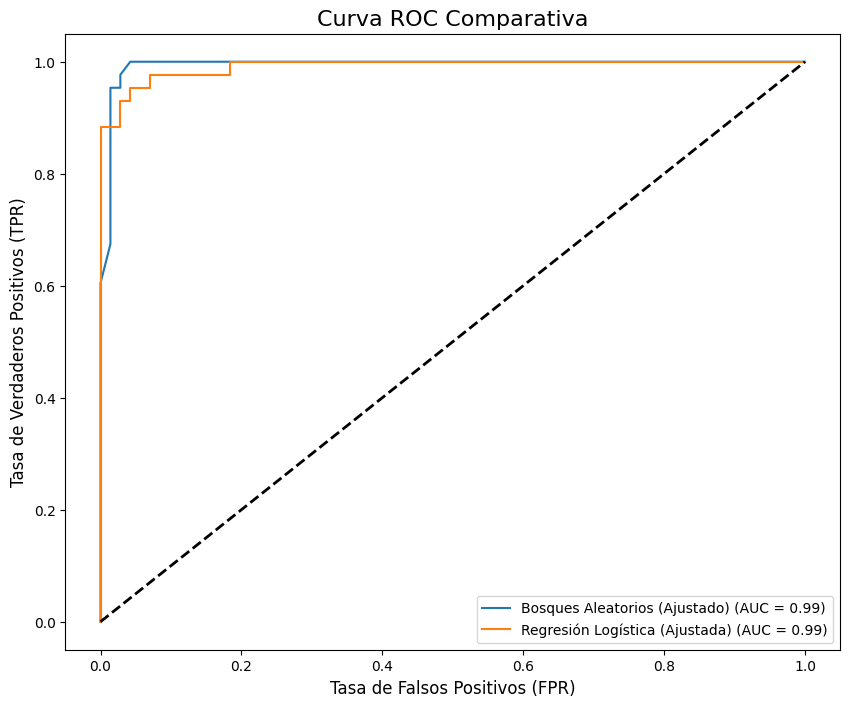

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Modelos ajustados con los mejores hiperparámetros
models = {
    "Bosques Aleatorios (Ajustado)": grid_search_rf.best_estimator_,
    "Regresión Logística (Ajustada)": grid_search_logreg.best_estimator_
}

# Generar Curvas ROC
plt.figure(figsize=(10, 8))
for name, model in models.items():
    # Obtener probabilidades para la clase positiva (1)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Graficar
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Línea diagonal como referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configuración de la gráfica
plt.title("Curva ROC Comparativa", fontsize=16)
plt.xlabel("Tasa de Falsos Positivos (FPR)", fontsize=12)
plt.ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=12)
plt.legend(loc="lower right")
plt.show()


La gráfica Curva ROC Comparativa indica un excelente rendimiento de los modelos evaluados (Bosques Aleatorios y Regresión Logística) en términos de discriminación entre las clases benigno y maligno. Ambos presentan un Área Bajo la Curva (AUC) de 0.99, lo que significa que tienen una capacidad casi perfecta para distinguir entre las dos categorías.

# Importancia de Características

C:\Users\Propietario\AppData\Local\Temp\ipykernel_14268\1851603166.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=features.head(10), x='Importance', y='Feature', palette="coolwarm")


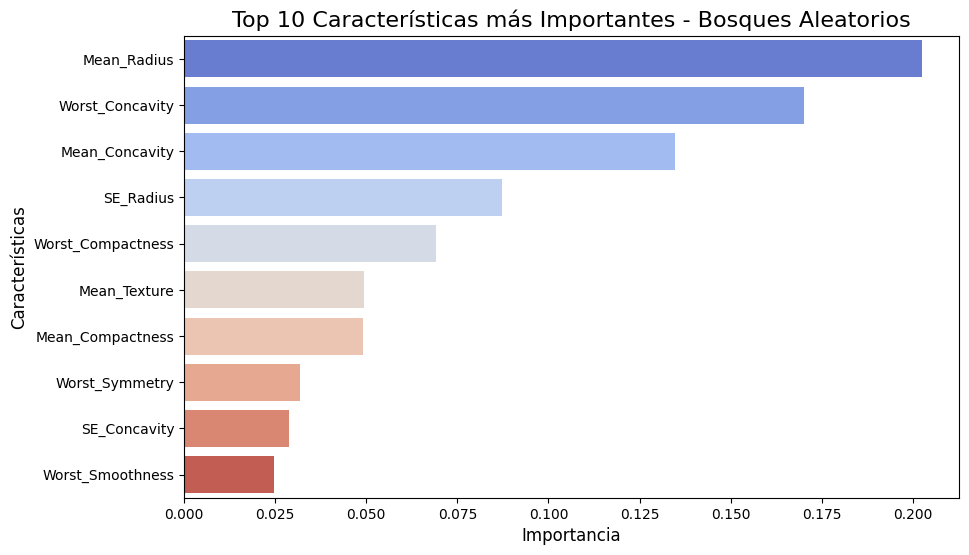

Importancia de las Características:
                     Feature  Importance
0               Mean_Radius    0.202525
17          Worst_Concavity    0.170028
4            Mean_Concavity    0.134734
7                 SE_Radius    0.087134
16        Worst_Compactness    0.069220
1              Mean_Texture    0.049379
3          Mean_Compactness    0.049048
18           Worst_Symmetry    0.031817
11             SE_Concavity    0.028763
15         Worst_Smoothness    0.024632
6    Mean_Fractal_Dimension    0.022246
2           Mean_Smoothness    0.020719
14     SE_Fractal_Dimension    0.019632
10           SE_Compactness    0.017178
9             SE_Smoothness    0.014472
12        SE_Concave_Points    0.014285
19  Worst_Fractal_Dimension    0.011934
8                SE_Texture    0.011328
13              SE_Symmetry    0.010887
5             Mean_Symmetry    0.010038


In [12]:
# Importancia de características para Bosques Aleatorios
# Extraer la importancia de cada característica
feature_importances = grid_search_rf.best_estimator_.feature_importances_

# Crear un DataFrame para ordenar y visualizar
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizar las 10 características más importantes
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(data=features.head(10), x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Características más Importantes - Bosques Aleatorios", fontsize=16)
plt.xlabel("Importancia", fontsize=12)
plt.ylabel("Características", fontsize=12)
plt.show()

# Imprimir todas las características ordenadas por importancia
print("Importancia de las Características:\n", features)


### Características Más Importantes:

Mean_Radius (0.2025):

Es la característica más influyente. Tiene sentido porque el tamaño promedio del radio de un tumor puede ser un fuerte indicador de malignidad.

** Worst_Concavity (0.1700) y Mean_Concavity (0.1347):

Estas características describen las irregularidades del contorno del tumor. Tumores malignos suelen tener mayores concavidades, lo que las convierte en variables clave.

SE_Radius (0.0871):

La desviación estándar del radio también es relevante, probablemente porque los tumores malignos tienden a presentar más variaciones en sus mediciones.

Worst_Compactness (0.0692):

Compactness mide la densidad del tumor. Un valor extremo puede ser característico de tumores malignos.

** Mean_Texture y Mean_Compactness (~0.049):

Aunque tienen menor importancia comparativa, su influencia aún es significativa para identificar patrones en los tumores.

## Análisis de la Gráfica:

La gráfica resalta las 10 principales características con barras ordenadas por importancia. Esto hace evidente que variables relacionadas con el tamaño (como Mean_Radius) y las irregularidades geométricas (como Worst_Concavity y Mean_Concavity) tienen un impacto directo en el diagnóstico.

Además, la dispersión en los valores de importancia muestra que el modelo pone más peso en las variables altamente discriminativas.

## Conclusión:
Estas características clave no solo ofrecen insights biológicos sobre los tumores, sino que también aseguran que el modelo sea capaz de tomar decisiones predictivas basadas en variables significativas.